In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage
import yaml
#from pyevtk.hl import imageToVTK 
from skimage import io
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage import morphology

# read parameters

In [3]:
with open("../base/parameters.yml") as file:
    parameters = yaml.load(file, Loader=yaml.FullLoader)
with open("../local/parameters.yml") as file:
    parameters_local = yaml.load(file, Loader=yaml.FullLoader)

# overwrite global parameters with local setting
for key in parameters_local:
    parameters[key] = parameters_local[key]
    
print(parameters)

{'data_folder': '/home/ebauman/Data/zebrafish_xenograft/', 'output_folder': '/home/ebauman/Data/zebrafish_xenograft/', 'sigma': 5}


# specify and read tiff images

In [ ]:
#data_folder = parameters["data_folder"]
data_folder = '/home/ebauman/Data/zebrafish_xenograft/03_Processed_Data/3D/'

#filename_short = "200811_Pos002"
#macrophage_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_macrophages3D.tif"
#im_macrophages = np.array(io.imread(data_folder + macrophage_file))
#tumor_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_tumor3D.tif"
#im_tumor = np.array(io.imread(data_folder + tumor_file))
#vessel_file = "200811 mpeg-mCherry x kdrl-lynEYFP LBT123 1in27 GFP 2dpf 1dpi Ti30min_Mark_and_Find003_Position002_vessels3D.tif"
#im_vessel = np.array(io.imread(data_folder + vessel_file))

filename = "200804_LBT070_1dpi_Pos001.tif"
filename_short = "200804_Pos001"
im = np.array(io.imread(data_folder + filename))

In [4]:
print(im.shape)

im_tumor = im[:,:,:,:,0]
im_macrophages = im[:,:,:,:,1]
im_vessel = im[:,:,:,:,2]

(33, 128, 1024, 1024, 3)


In [1]:
im_tumor.shape[0]

NameError: name 'im_tumor' is not defined

# smooth images

In [5]:
###### smooth just one time point
sigma0 = 5

im_macrophage_smoothed = gaussian_filter(im_macrophages[0,:,:,:], sigma = sigma0)
im_tumor_smoothed = gaussian_filter(im_tumor[0,:,:,:], sigma = sigma0)
im_vessel_smoothed = gaussian_filter(im_vessel[0,:,:,:], sigma = sigma0)

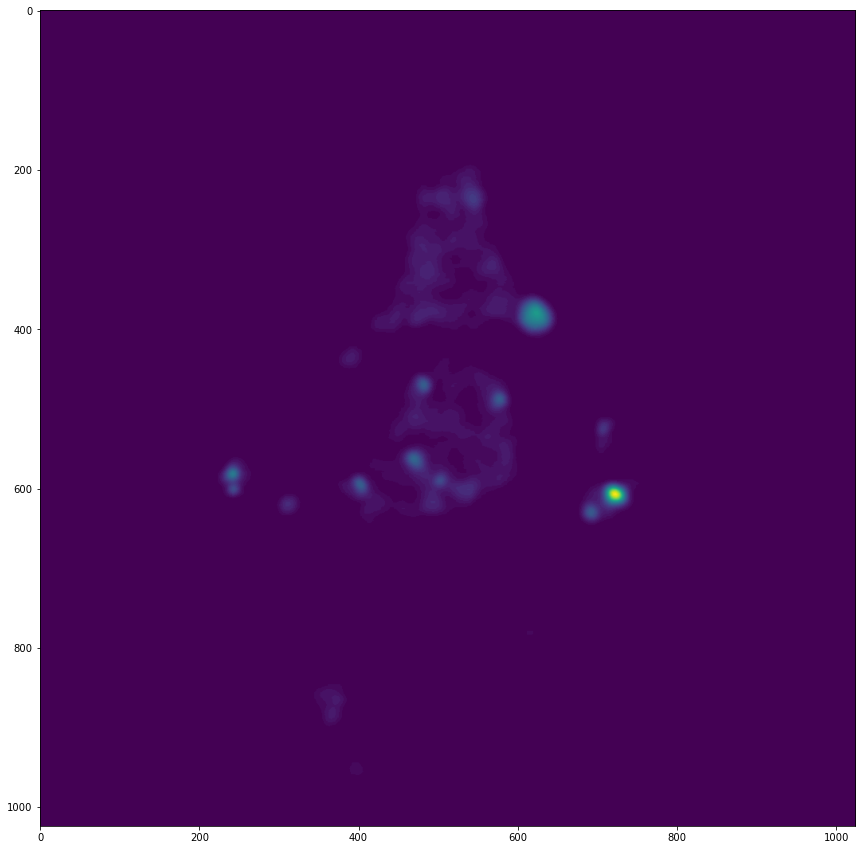

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im_macrophage_smoothed[50,:,:])
#ax.imshow(np.amax(im_macrophage_smoothed, axis=0))

In [9]:
##### smooth all time points
im_macrophage_smoothed_allFrames = np.zeros(im_macrophages.shape)
for tp in range(im_macrophages.shape[0]):
    # simply running the Gaussian filter over the whole data set without looping through the different time points
    # didn't show the same smoothing
    #print(tp)
    im_macrophage_smoothed_allFrames[tp] = gaussian_filter(im_macrophages[tp], sigma = sigma0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


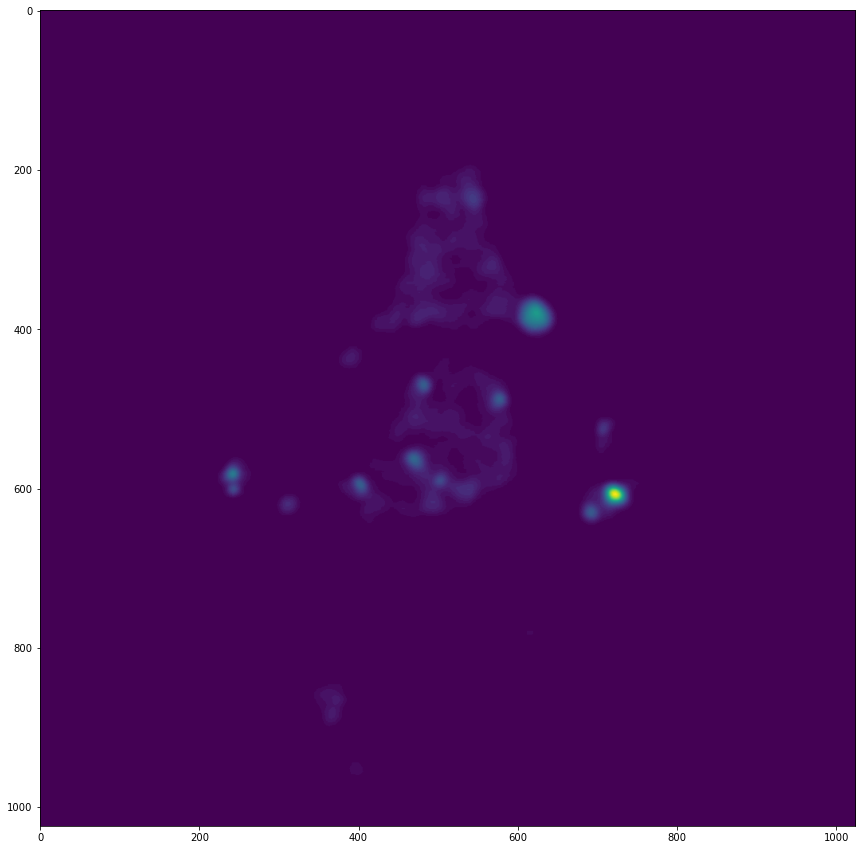

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im_macrophage_smoothed_allFrames[0,50,:,:])

# count macrophages

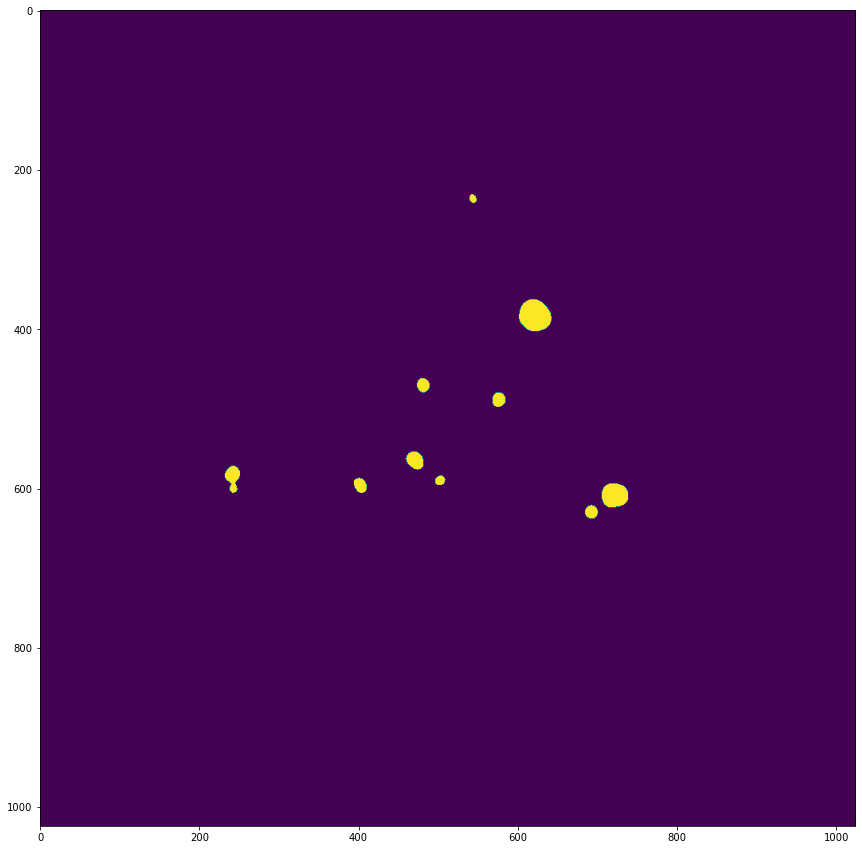

In [11]:
######## OTSU threshold of single frame 
macrophages_mask = np.where(im_macrophage_smoothed > threshold_otsu(im_macrophage_smoothed), True, False)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(macrophages_mask[50,:,:])
#ax.imshow(np.amax(macrophages_mask, axis = 0))

In [22]:
###### OTSU threshold of all frames
macrophages_mask_allFrames = np.zeros(im_macrophage_smoothed_allFrames.shape, dtype=bool)
for tp in range(im_macrophage_smoothed_allFrames.shape[0]):
    #print(tp)
    macrophages_mask_allFrames[tp] = np.where(im_macrophage_smoothed_allFrames[tp] > threshold_otsu(im_macrophage_smoothed_allFrames[tp]), True, False)

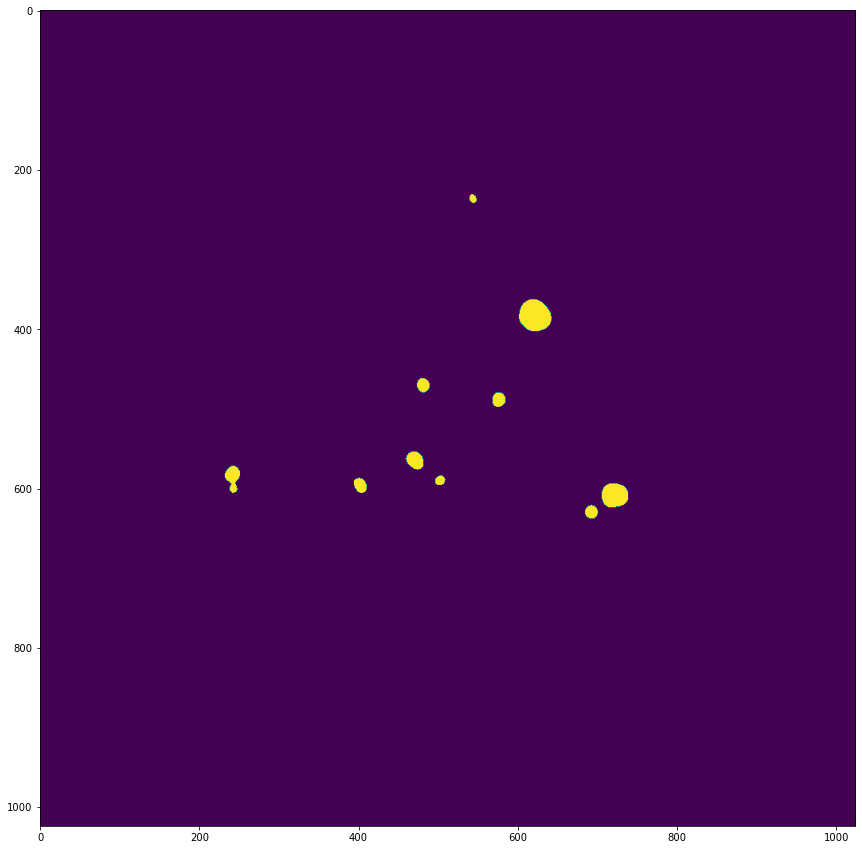

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(macrophages_mask_allFrames[0,50,:,:])

In [16]:
######## count macrophages from single frame
# remove artifacts connected to image border
cleared = clear_border(macrophages_mask)
cleared = morphology.remove_small_objects(cleared, 2500, connectivity=2)

# label image regions
label_image = label(cleared)
print("Number of macrophages %s" % np.max(label_image))

Number of macrophages 27


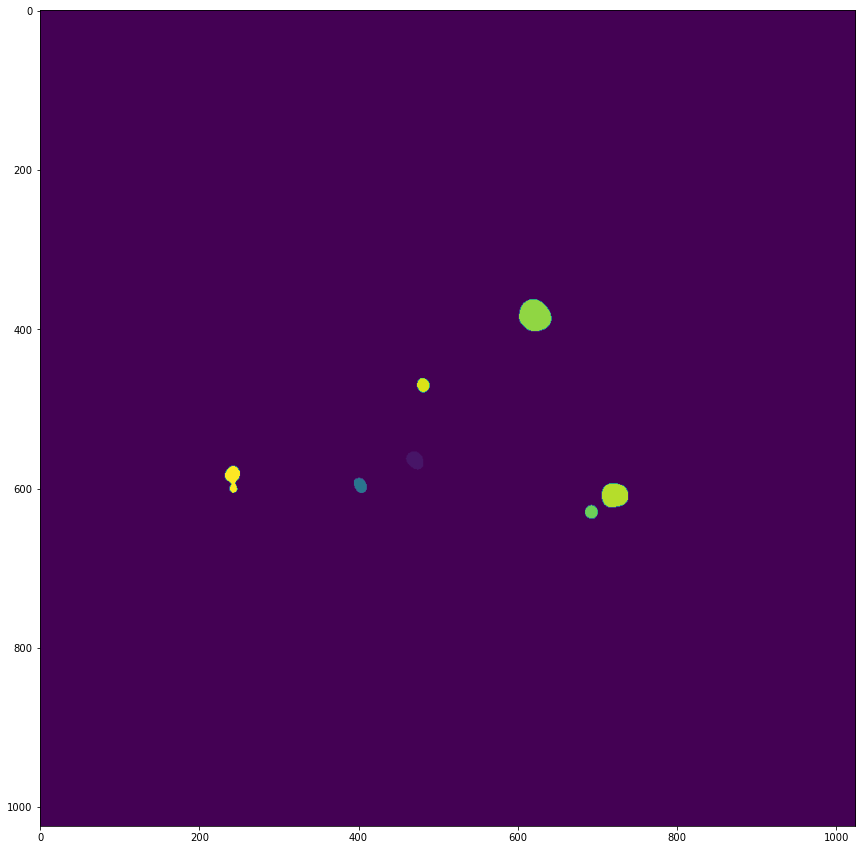

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(label_image[50,:,:])
#ax.imshow(np.amax(label_image, axis=0))

In [ ]:
######## count macrophages for all frames
# remove artifacts connected to image border
cleared_allFrames = np.zeros(macrophages_mask_allFrames.shape, dtype = bool)
label_image = np.zeros(macrophages_mask_allFrames.shape)
for tp in range(macrophages_mask_allFrames.shape[0]):
    cleared_allFrames[tp] = clear_border(macrophages_mask_allFrames[tp])
    cleared_allFrames[tp] = morphology.remove_small_objects(cleared_allFrames[tp], 2500, connectivity=2)
    # label image regions
    label_image[tp] = label(cleared_allFrames[tp])
    print("Number of macrophages %s" % np.max(label_image[tp]))

0
Number of macrophages 27.0
1
Number of macrophages 31.0
2
Number of macrophages 36.0
3
Number of macrophages 40.0
4
Number of macrophages 41.0
5
Number of macrophages 45.0
6
Number of macrophages 33.0
7
Number of macrophages 37.0
8
Number of macrophages 47.0
9
Number of macrophages 37.0
10
Number of macrophages 33.0
11
Number of macrophages 28.0
12
Number of macrophages 30.0
13
Number of macrophages 37.0
14
Number of macrophages 32.0
15
Number of macrophages 27.0
16
Number of macrophages 27.0
17
Number of macrophages 32.0
18
Number of macrophages 25.0
19
Number of macrophages 29.0
20
Number of macrophages 26.0
21
Number of macrophages 26.0
22
Number of macrophages 30.0
23
Number of macrophages 32.0
24
Number of macrophages 26.0
25
Number of macrophages 24.0
26
Number of macrophages 29.0
27
Number of macrophages 29.0
28
Number of macrophages 19.0
29
Number of macrophages 30.0
30
Number of macrophages 31.0
31
Number of macrophages 26.0
32


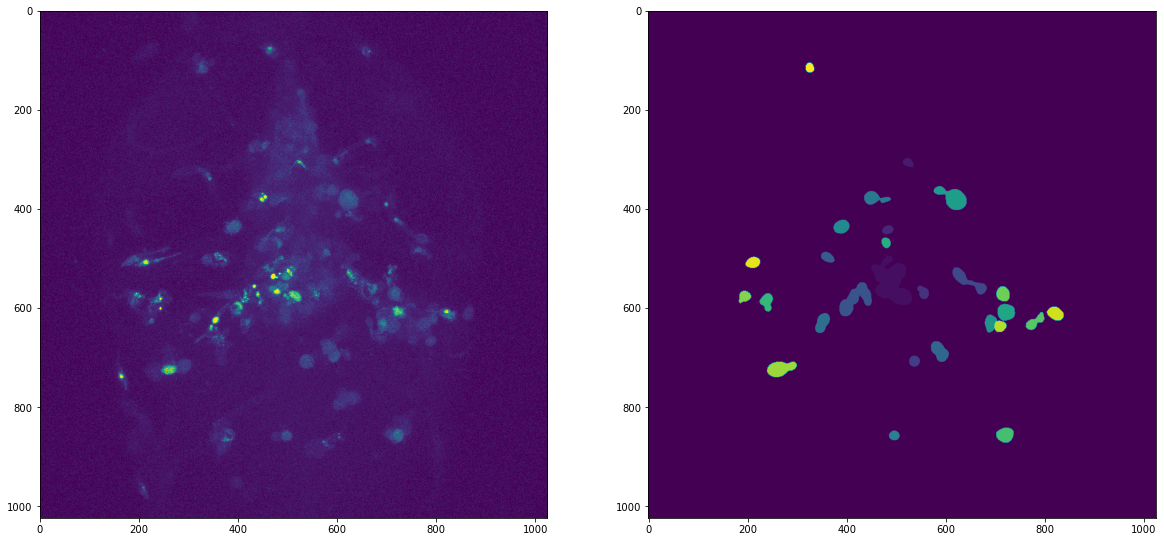

In [37]:
# compare original and mask 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax1.imshow(np.amax(im_macrophages[0], axis=0))
ax2.imshow(np.amax(label_image, axis=0))

In [ ]:
output_folder = parameters["output_folder"]
    
filename = output_folder + "labeled_macrophages"
imageToVTK(filename, cellData = {"macrophages" : label_image})